Make Window from geotiff

In [2]:
import numpy
from pathlib  import Path
from matplotlib import pyplot as plt
import numpy as np
from copy import copy
import rioxarray
import xarray
import a301_lib

in a301_lib init


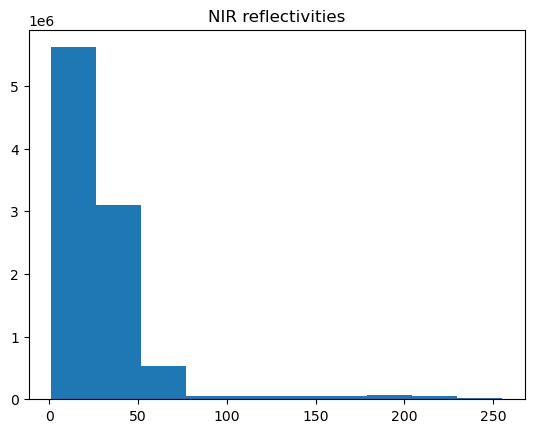

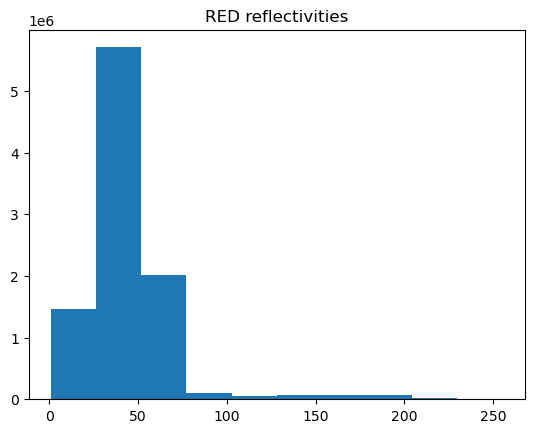

In [9]:
#infile = a301_lib.sat_data / f"ajb/aut2023_hls_landsat8_4.tif"
#infile = a301_lib.sat_data / f"ajb/eruption/LM02_L1TP_049028_19800731_20200905_02_T2_B5.TIF"
#infile = a301_lib.sat_data / f"ajb/eruption/LM02_L1TP_049028_19800731_20200905_02_T2_B6.TIF"
infile1 = a301_lib.sat_data / f"ajb/eruption/LM03_L1TP_049028_19791008_20200906_02_T2_B5.TIF"
infile2 = a301_lib.sat_data / f"ajb/eruption/LM03_L1TP_049028_19791008_20200906_02_T2_B6.TIF"

#infile1 = a301_lib.sat_data / "ajb/landsat7/nir/2003-02-06_nir.tiff"
#infile2 = a301_lib.sat_data / "ajb/landsat7/red/2003-02-06_red.tiff"

band_name1 = "NIR"
band_name2 = "RED"
the_band1 = rioxarray.open_rasterio(infile1,masked=True) 
the_band2 = rioxarray.open_rasterio(infile2,masked=True) 

scaled_band1 = the_band1*the_band1.scale_factor
masked_band1 = scaled_band1

scaled_band2 = the_band2*the_band2.scale_factor
masked_band2 = scaled_band2

fig, ax = plt.subplots(1,1)
masked_band1.plot.hist(ax = ax)
ax.set(title="NIR reflectivities");

fig, ax = plt.subplots(1,1)
masked_band2.plot.hist(ax = ax)
ax.set(title="RED reflectivities");

Text(0.5, 1.0, 'Landsat band RED')

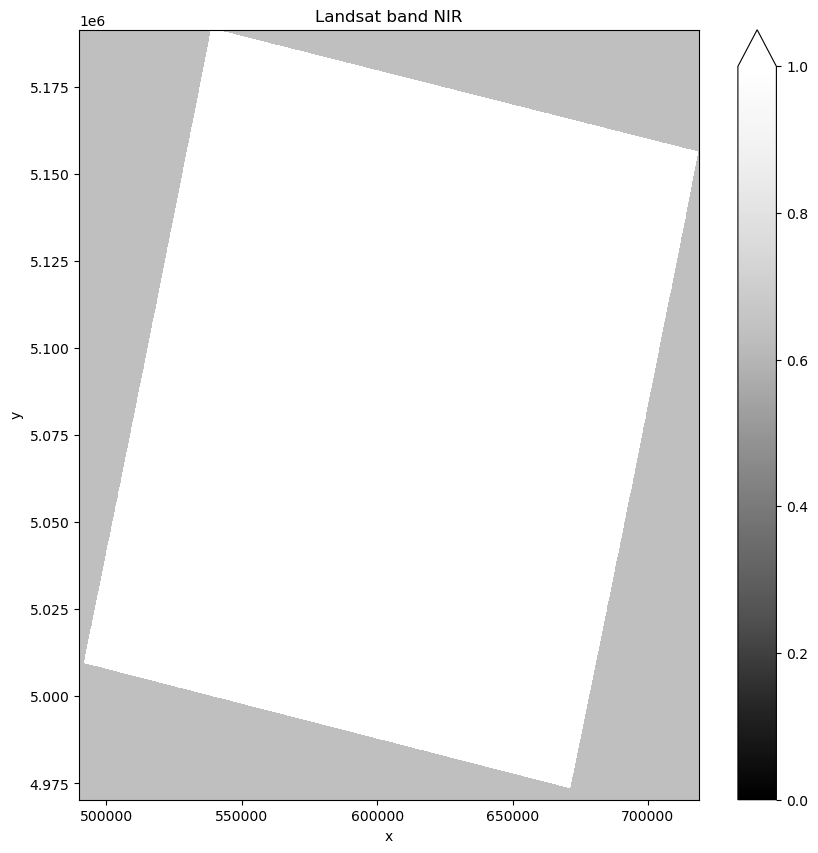

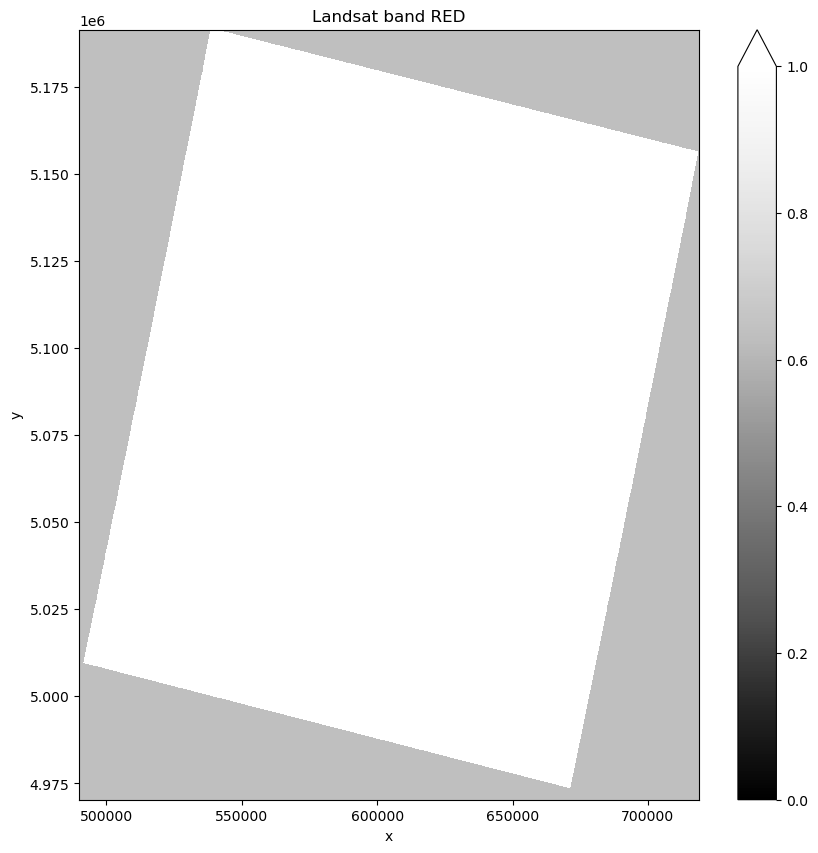

In [10]:
pal = copy(plt.get_cmap("Greys_r"))
pal.set_bad("0.75")  # 75% grey for out-of-map cells
pal.set_over("w")  # color cells > vmax red
pal.set_under("k")  # color cells < vmin black
vmin = 0.0  #anything under this is colored black
vmax = 1.0  #anything over this is colored red
from matplotlib.colors import Normalize
the_norm = Normalize(vmin=vmin, vmax=vmax, clip=False)

fig, ax = plt.subplots(1,1, figsize=(10,10))
masked_band1.plot(ax=ax, cmap=pal, norm = the_norm)
ax.set_title(f"Landsat band {band_name1}")

fig, ax = plt.subplots(1,1, figsize=(10,10))
masked_band2.plot(ax=ax, cmap=pal, norm = the_norm)
ax.set_title(f"Landsat band {band_name2}")

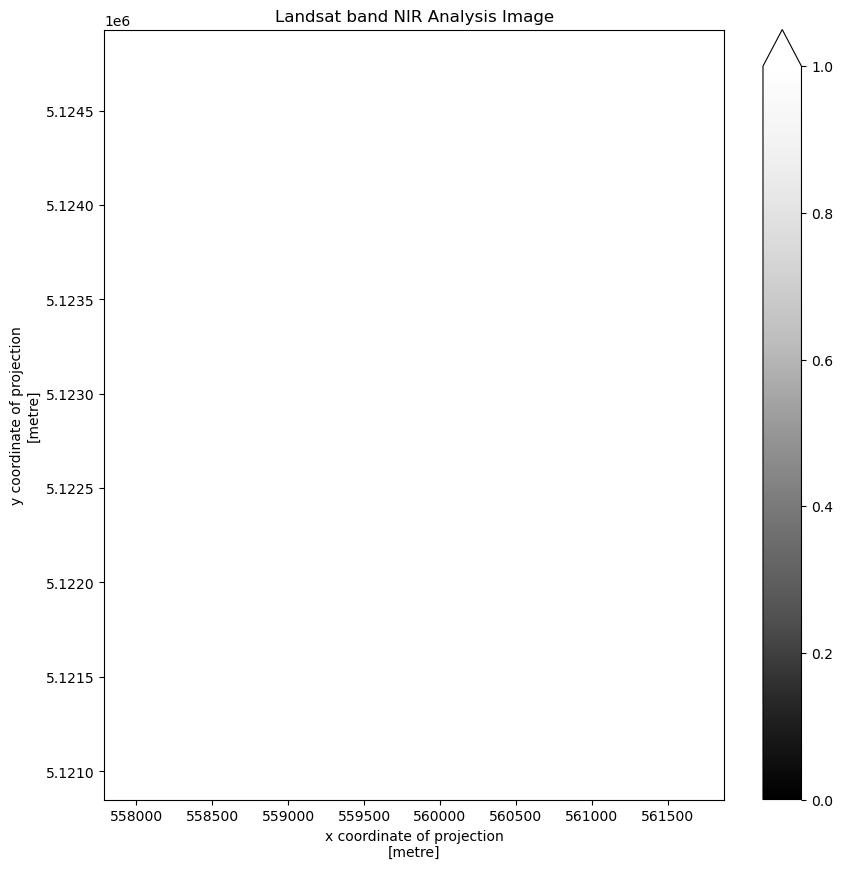

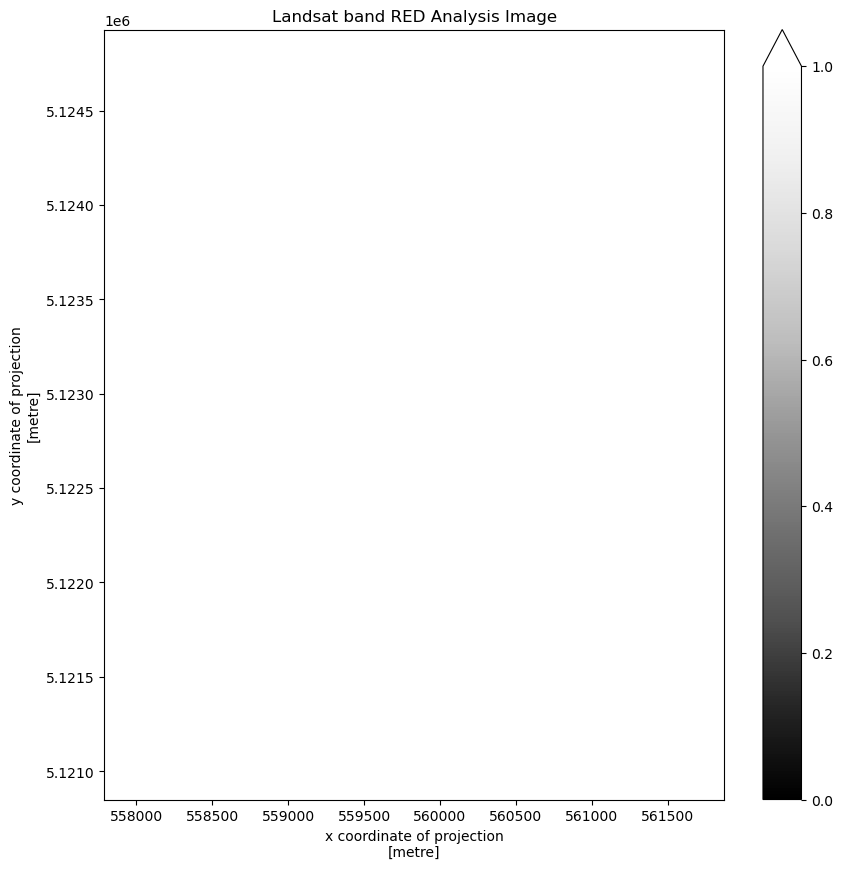

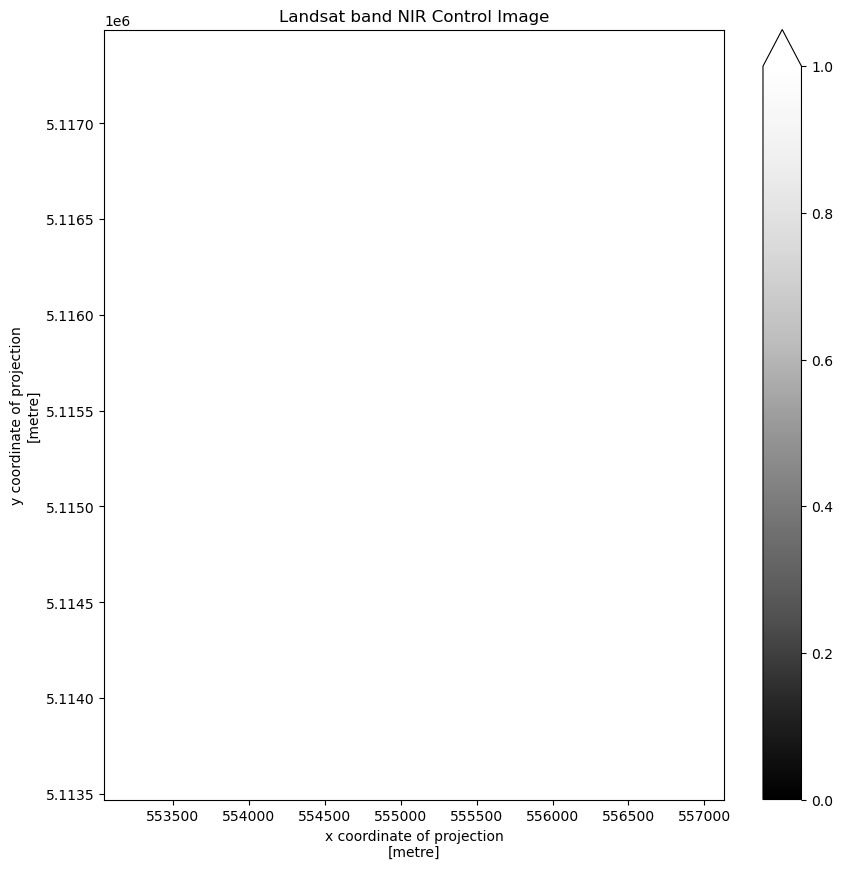

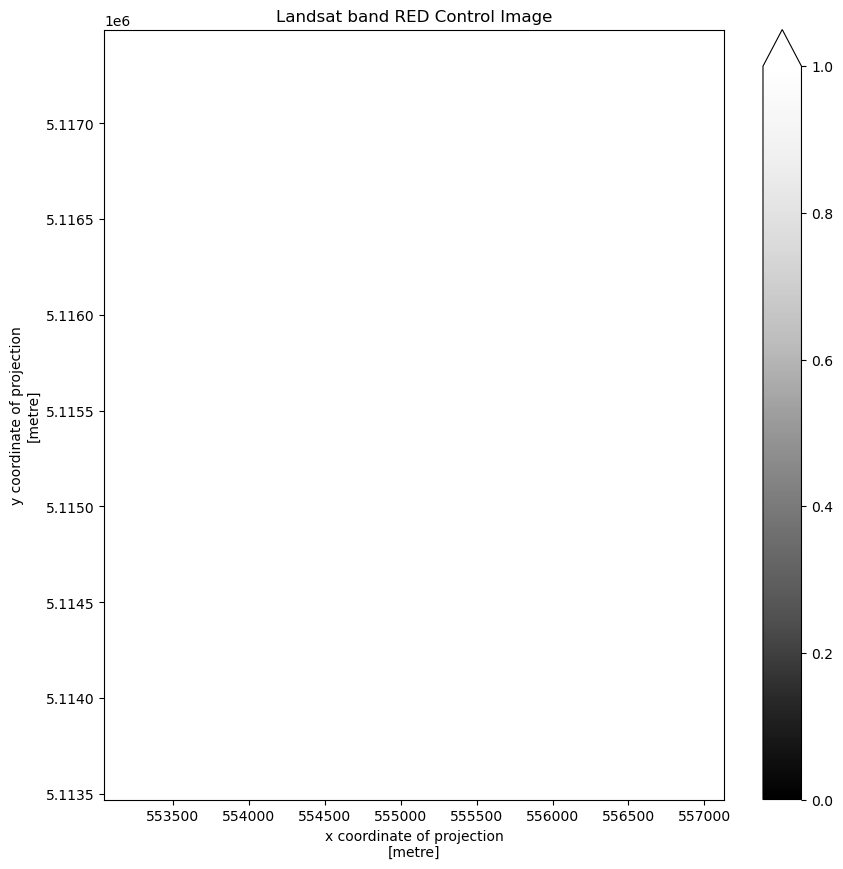

In [11]:
# Create a Cartopy Map Projection
import cartopy.crs as ccrs
import cartopy
from pyresample.utils.cartopy import Projection

cartopy_crs = Projection(the_band1.rio.crs, the_band1.rio.bounds())

ana_lon, ana_lat = -122.223611, 46.257066 #St Helens analysis region
con_lat, con_lon = 46.190630, -122.286143 #St Helens control region
ana_x, ana_y = cartopy_crs.transform_point(ana_lon,ana_lat,ccrs.Geodetic())
con_x, con_y = cartopy_crs.transform_point(con_lon,con_lat,ccrs.Geodetic())

#make a 2 km x 2 km box around each point

ana_ll_x = ana_x - 2000
ana_ll_y = ana_y - 2000
ana_ur_x = ana_x + 2000
ana_ur_y = ana_y + 2000

con_ll_x = con_x - 2000
con_ll_y = con_y - 2000
con_ur_x = con_x + 2000
con_ur_y = con_y + 2000

ana_bounding_box = ana_ll_x, ana_ll_y, ana_ur_x, ana_ur_y
con_bounding_box = con_ll_x, con_ll_y, con_ur_x, con_ur_y

ana1 = masked_band1.rio.clip_box(*ana_bounding_box)
con1 = masked_band1.rio.clip_box(*con_bounding_box)

ana2 = masked_band2.rio.clip_box(*ana_bounding_box)
con2 = masked_band2.rio.clip_box(*con_bounding_box)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ana1.plot(ax=ax, cmap=pal, norm = the_norm)
ax.set_title(f"Landsat band {band_name1} Analysis Image");

fig, ax = plt.subplots(1,1, figsize=(10,10))
ana2.plot(ax=ax, cmap=pal, norm = the_norm)
ax.set_title(f"Landsat band {band_name2} Analysis Image");

fig, ax = plt.subplots(1,1, figsize=(10,10))
con1.plot(ax=ax, cmap=pal, norm = the_norm)
ax.set_title(f"Landsat band {band_name1} Control Image");

fig, ax = plt.subplots(1,1, figsize=(10,10))
con2.plot(ax=ax, cmap=pal, norm = the_norm)
ax.set_title(f"Landsat band {band_name2} Control Image");

In [15]:
# Write as a new Geotiff

from affine import Affine
from rioxarray.rioxarray import affine_to_coords

orig = the_band1.rio.transform()
a,b,d,e = orig.a, orig.b, orig.d, orig.e
c = ana_ll_x  # upper left x
f = ana_ur_y  # uper left y
ana_new_transform = Affine(a,b,c,d,e,f)

orig = the_band1.rio.transform()
a,b,d,e = orig.a, orig.b, orig.d, orig.e
c = con_ll_x  # upper left x
f = con_ur_y  # upper left y
con_new_transform = Affine(a,b,c,d,e,f)

ana_band, ana_height, ana_width = ana1.data.shape
ana_coords = affine_to_coords(ana_new_transform,ana_width,ana_height)

con_band, con_height, con_width = con1.data.shape
con_coords = affine_to_coords(con_new_transform,con_width,con_height)

ana_clipped_ds=xarray.DataArray(ana1.data,coords=ana_coords,
                                dims=ana1.dims,
                                attrs=the_band1.attrs)

con_clipped_ds=xarray.DataArray(con1.data,coords=con_coords,
                                dims=con1.dims,
                                attrs=the_band1.attrs)

ana_clipped_ds.rio.write_crs(the_band1.rio.crs, inplace=True)
ana_clipped_ds.rio.write_transform(ana_new_transform, inplace=True);

con_clipped_ds.rio.write_crs(the_band1.rio.crs, inplace=True)
con_clipped_ds.rio.write_transform(con_new_transform, inplace=True);

#outfile = a301_lib.sat_data / "ajb/sthelens_clipped_analysisregion.tif"
#outfile = a301_lib.sat_data / f"ajb/initial_sthelens_clipped_analysisregion_{band_name}.tif"
outfile = a301_lib.sat_data / f"ajb/before_sthelens_clipped_analysisregion_{band_name1}.tif"
ana_clipped_ds.rio.to_raster(outfile)

#outfile = a301_lib.sat_data / "ajb/sthelens_clipped_controlregion.tif"
#outfile = a301_lib.sat_data / f"ajb/initial_sthelens_clipped_controlregion_{band_name}.tif"
outfile = a301_lib.sat_data / f"ajb/before_sthelens_clipped_controlregion_{band_name1}.tif"
con_clipped_ds.rio.to_raster(outfile)

In [16]:
orig = the_band2.rio.transform()
a,b,d,e = orig.a, orig.b, orig.d, orig.e
c = ana_ll_x  # upper left x
f = ana_ur_y  # uper left y
ana_new_transform = Affine(a,b,c,d,e,f)

orig = the_band2.rio.transform()
a,b,d,e = orig.a, orig.b, orig.d, orig.e
c = con_ll_x  # upper left x
f = con_ur_y  # upper left y
con_new_transform = Affine(a,b,c,d,e,f)

ana_band, ana_height, ana_width = ana2.data.shape
ana_coords = affine_to_coords(ana_new_transform,ana_width,ana_height)

con_band, con_height, con_width = con2.data.shape
con_coords = affine_to_coords(con_new_transform,con_width,con_height)

ana_clipped_ds=xarray.DataArray(ana2.data,coords=ana_coords,
                                dims=ana2.dims,
                                attrs=the_band2.attrs)

con_clipped_ds=xarray.DataArray(con2.data,coords=con_coords,
                                dims=con2.dims,
                                attrs=the_band2.attrs)

ana_clipped_ds.rio.write_crs(the_band2.rio.crs, inplace=True)
ana_clipped_ds.rio.write_transform(ana_new_transform, inplace=True);

con_clipped_ds.rio.write_crs(the_band2.rio.crs, inplace=True)
con_clipped_ds.rio.write_transform(con_new_transform, inplace=True);

#outfile = a301_lib.sat_data / "ajb/sthelens_clipped_analysisregion.tif"
#outfile = a301_lib.sat_data / f"ajb/initial_sthelens_clipped_analysisregion_{band_name}.tif"
outfile = a301_lib.sat_data / f"ajb/before_sthelens_clipped_analysisregion_{band_name2}.tif"
ana_clipped_ds.rio.to_raster(outfile)

#outfile = a301_lib.sat_data / "ajb/sthelens_clipped_controlregion.tif"
#outfile = a301_lib.sat_data / f"ajb/initial_sthelens_clipped_controlregion_{band_name}.tif"
outfile = a301_lib.sat_data / f"ajb/before_sthelens_clipped_controlregion_{band_name2}.tif"
con_clipped_ds.rio.to_raster(outfile)

In [20]:
# big original
landsat_dir = a301_lib.sat_data / "ajb"
orig_file = landsat_dir / f"aut2023_hls_landsat8_4.tif"
new_orig_file = a301_lib.sat_data / f"ajb/eruption/LM03_L1TP_049028_19791008_20200906_02_T2_B5.TIF"
orig_ds = rioxarray.open_rasterio(orig_file,mask_and_scale=True)
new_orig_ds = rioxarray.open_rasterio(new_orig_file,mask_and_scale=True)
orig_transform = orig_ds.rio.transform()
new_orig_transform = new_orig_ds.rio.transform()

# analysis clipped region
ana_clipped_file = a301_lib.sat_data / "ajb/sthelens_clipped_analysisregion.tif"
ana_clipped_ds = rioxarray.open_rasterio(ana_clipped_file, mask_and_scale=True)
ana_clipped_transform = ana_clipped_ds.rio.transform()
ana_clipped_bounds = ana_clipped_ds.rio.bounds()

ana_clipped_file = a301_lib.sat_data / "ajb/before_sthelens_clipped_analysisregion_B5.tif"
ana_clipped_ds = rioxarray.open_rasterio(ana_clipped_file, mask_and_scale=True)
ana_clipped_transform = ana_clipped_ds.rio.transform()
new_ana_clipped_bounds = ana_clipped_ds.rio.bounds()

# control clipped region
con_clipped_file = a301_lib.sat_data / "ajb/sthelens_clipped_controlregion.tif"
con_clipped_ds = rioxarray.open_rasterio(con_clipped_file, mask_and_scale=True)
con_clipped_transform = con_clipped_ds.rio.transform()
con_clipped_bounds = con_clipped_ds.rio.bounds()

con_clipped_file = a301_lib.sat_data / "ajb/before_sthelens_clipped_controlregion_B5.tif"
con_clipped_ds = rioxarray.open_rasterio(con_clipped_file, mask_and_scale=True)
con_clipped_transform = con_clipped_ds.rio.transform()
new_con_clipped_bounds = con_clipped_ds.rio.bounds()

In [21]:
# Display the analysis region's bounds
ana_clipped_bounds

(557838.5060549728, 5120852.838567851, 561858.5060549728, 5124902.838567851)

In [22]:
# Display the control region's bounds
con_clipped_bounds

(553085.4087842406, 5113455.793074745, 557105.4087842406, 5117475.793074745)

In [23]:
import rasterio

ana_window = rasterio.windows.from_bounds(*ana_clipped_bounds, 
                                          transform=orig_transform)
con_window = rasterio.windows.from_bounds(*con_clipped_bounds,
                                          transform=orig_transform)

ana_window = ana_window.round_lengths()
ana_window = ana_window.round_offsets()

con_window = con_window.round_lengths()
con_window = con_window.round_offsets()

In [24]:
ana_window

Window(col_off=1928, row_off=2504, width=134, height=135)

In [25]:
con_window

Window(col_off=1770, row_off=2751, width=134, height=134)

In [26]:
ana_row_slice, ana_col_slice = ana_window.toslices()
ana_row_slice, ana_col_slice

(slice(2504, 2639, None), slice(1928, 2062, None))

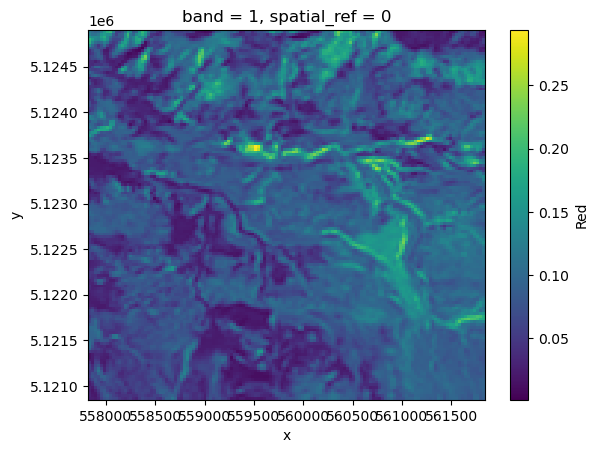

In [27]:
# Check the analysis window
check_window = orig_ds[0,ana_row_slice,ana_col_slice] 
check_window.plot();

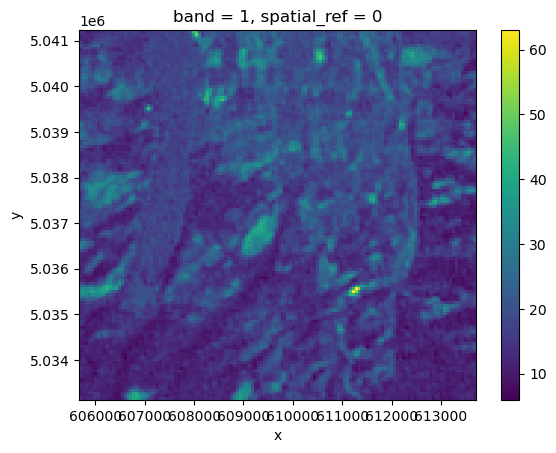

In [28]:
check_window = new_orig_ds[0,ana_row_slice,ana_col_slice] 
check_window.plot();

In [29]:
con_row_slice, con_col_slice = con_window.toslices()
con_row_slice, con_col_slice

(slice(2751, 2885, None), slice(1770, 1904, None))

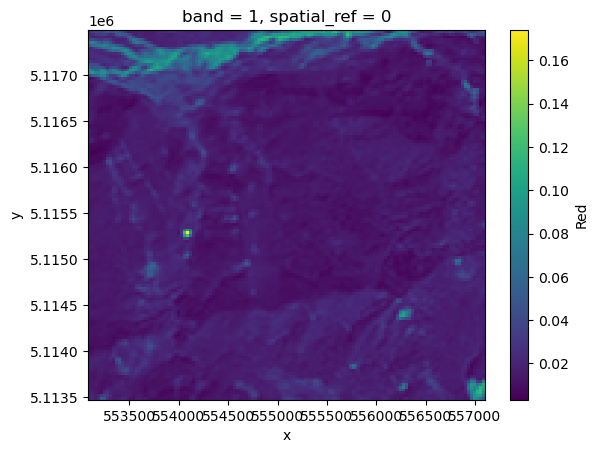

In [30]:
#Check the control window
check_window = orig_ds[0,con_row_slice,con_col_slice]  
check_window.plot();

In [31]:
import utm

In [32]:
ll_ana = utm.to_latlon(ana_clipped_bounds[0],ana_clipped_bounds[1], 10, "N")
ur_ana = utm.to_latlon(ana_clipped_bounds[2],ana_clipped_bounds[3], 10, "N")
lr_ana = utm.to_latlon(ana_clipped_bounds[2],ana_clipped_bounds[1], 10, "N")
ul_ana = utm.to_latlon(ana_clipped_bounds[0],ana_clipped_bounds[3], 10, "N")

ll_con = utm.to_latlon(con_clipped_bounds[0],con_clipped_bounds[1], 10, "N")
ur_con = utm.to_latlon(con_clipped_bounds[2],con_clipped_bounds[3], 10, "N")
lr_con = utm.to_latlon(con_clipped_bounds[2],con_clipped_bounds[1], 10, "N")
ul_con = utm.to_latlon(con_clipped_bounds[0],con_clipped_bounds[3], 10, "N")

In [33]:
print(ll_ana, ur_ana, lr_ana, ul_ana)
print(ll_con, ur_con, lr_con, ul_con)

(46.238790943502416, -122.24980973246753) (46.27488310700656, -122.1971418720139) (46.23843693731459, -122.19767362812013) (46.27523756126233, -122.24931252231255)
(46.17261009526884, -122.31228596186294) (46.20846210185249, -122.25972612156839) (46.17228494983489, -122.26021167444048) (46.2087876557444, -122.3118345806219)


In [34]:
ll_ana = utm.to_latlon(new_ana_clipped_bounds[0],new_ana_clipped_bounds[1], 10, "N")
ur_ana = utm.to_latlon(new_ana_clipped_bounds[2],new_ana_clipped_bounds[3], 10, "N")
lr_ana = utm.to_latlon(new_ana_clipped_bounds[2],new_ana_clipped_bounds[1], 10, "N")
ul_ana = utm.to_latlon(new_ana_clipped_bounds[0],new_ana_clipped_bounds[3], 10, "N")

ll_con = utm.to_latlon(new_con_clipped_bounds[0],new_con_clipped_bounds[1], 10, "N")
ur_con = utm.to_latlon(new_con_clipped_bounds[2],new_con_clipped_bounds[3], 10, "N")
lr_con = utm.to_latlon(new_con_clipped_bounds[2],new_con_clipped_bounds[1], 10, "N")
ul_con = utm.to_latlon(new_con_clipped_bounds[0],new_con_clipped_bounds[3], 10, "N")

print(ll_ana, ur_ana, lr_ana, ul_ana)
print(ll_con, ur_con, lr_con, ul_con)

(46.23852096766977, -122.24981341191959) (46.27487763636197, -122.19636321311047) (46.23816150112081, -122.19689942372426) (46.27523756126233, -122.24931252231255)
(46.17261009526884, -122.31228596186294) (46.208457062964186, -122.25894839027204) (46.17227991726862, -122.25943445315208) (46.2087876557444, -122.3118345806219)


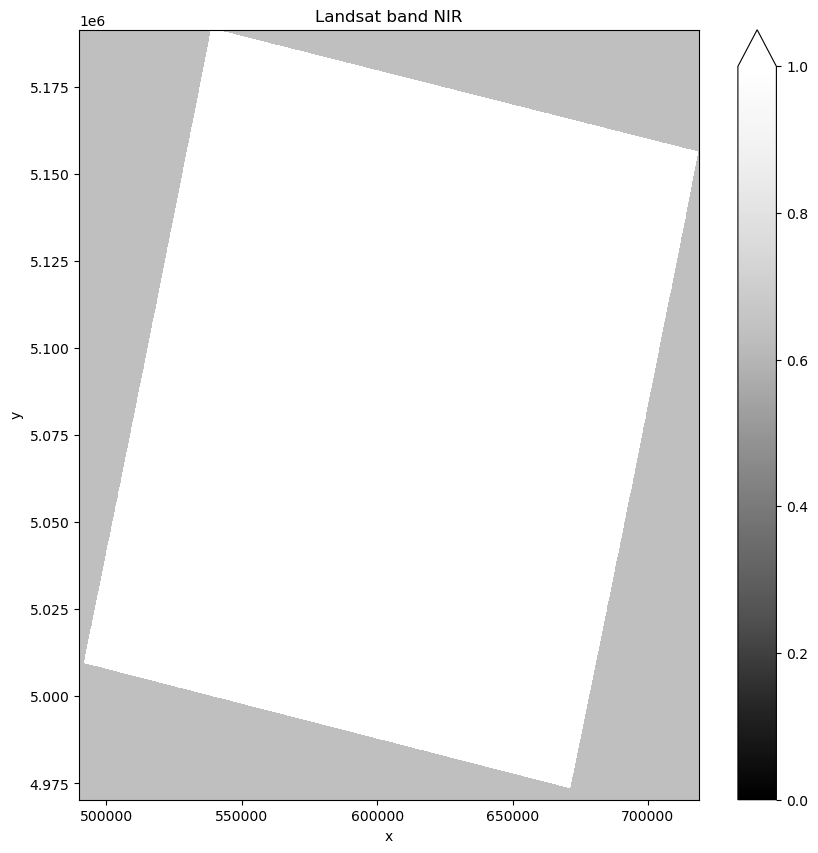

In [35]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
masked_band1.plot(ax=ax, cmap=pal, norm = the_norm)
ax.set_title(f"Landsat band {band_name1}")
ax.plot(ana_clipped_bounds[0],ana_clipped_bounds[1])